In [45]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("out_reviews/dataset_reviews.csv")

In [46]:
df.isna().sum()

Рейтинг          0
Год              0
Месяц            0
Источник         0
Текст отзыва    94
Автор            0
Дата_ISO         0
dtype: int64

In [47]:
# 6. Проверка наличия пропусков по строкам
missing_rows = df[df.isna().any(axis=1)]
print(f"Количество строк с пропусками: {len(missing_rows)}")
missing_rows.head()


Количество строк с пропусками: 94


,Рейтинг,Год,Месяц,Источник,Текст отзыва,Автор,Дата_ISO
97,5.0,2023,7,Google Maps,NaN,Nikita Seleznev,2023-07-05T07:32:07+00:00
98,5.0,2023,7,Google Maps,NaN,Nikita Seleznev,2023-07-05T07:32:07+00:00
99,5.0,2020,7,Google Maps,NaN,Рустам Журтов,2020-07-12T08:01:46+00:00
100,5.0,2022,2,Google Maps,NaN,MAGAS,2022-02-03T21:31:17+00:00
101,1.0,2021,12,Google Maps,NaN,Роман Колесов,2021-12-13T05:45:10+00:00


In [48]:
# 🧹 Подготовка дат

# Если в датасете уже есть Год/Месяц числовые — используем их.
# Иначе попытаемся реконструировать из свободной колонки даты, если она вдруг сохранилась.
if "Год" in df.columns and "Месяц" in df.columns:
    # Создадим дату первого числа месяца (для оси времени)
    df["Дата_месяц"] = pd.to_datetime(dict(year=df["Год"], month=df["Месяц"], day=1), errors="coerce")
else:
    # Попробуем найти колонку с датой (на случай, если ты сохранил "date" в этом файле)
    date_col = None
    for c in ["date", "published_date", "publish_time", "publishedTime", "time", "Дата"]:
        if c in df.columns:
            date_col = c
            break

    if date_col is None:
        raise RuntimeError("Не нашёл колонки Год/Месяц и явной колонки даты. Добавь Год/Месяц при формировании датасета.")

    def parse_date_safe(s):
        if pd.isna(s):
            return pd.NaT
        try:
            return pd.to_datetime(s, dayfirst=True, errors="raise")
        except Exception:
            try:
                return du_parser.parse(str(s), dayfirst=True)
            except Exception:
                return pd.NaT

    parsed = df[date_col].apply(parse_date_safe)
    df["Год"] = parsed.dt.year
    df["Месяц"] = parsed.dt.month
    df["Дата_месяц"] = pd.to_datetime(dict(year=df["Год"], month=df["Месяц"], day=1), errors="coerce")

# Приведём рейтинг к числу
if "Рейтинг" not in df.columns:
    raise RuntimeError("В датасете нет колонки 'Рейтинг'.")
df["Рейтинг"] = pd.to_numeric(df["Рейтинг"], errors="coerce")

# Текстовая колонка (для фильтрации позже)
text_col = None
for c in ["Текст отзыва", "text", "review_text", "snippet"]:
    if c in df.columns:
        text_col = c
        break

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Рейтинг       191 non-null    float64       
 1   Год           191 non-null    int64         
 2   Месяц         191 non-null    int64         
 3   Источник      191 non-null    object        
 4   Текст отзыва  97 non-null     object        
 5   Автор         191 non-null    object        
 6   Дата_ISO      191 non-null    object        
 7   Дата_месяц    191 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 12.1+ KB


In [49]:
df.head()

,Рейтинг,Год,Месяц,Источник,Текст отзыва,Автор,Дата_ISO,Дата_месяц
0,5.0,2025,6,Google Maps,понравилось все от видов за окном до вкусной е...,Tatyana,2025-06-09T23:59:59+00:00,2025-06-01
1,4.0,2024,7,Google Maps,Удобное расположение отеля.\r\nЕсть возможнос...,Svetlana,2024-07-28T23:59:59+00:00,2024-07-01
2,5.0,2023,7,Google Maps,Отель находится рядом с соляной Чешет и подъём...,Irina,2023-07-16T23:59:59+00:00,2023-07-01
3,4.0,2023,8,Google Maps,"Еда вкусная, сытная и разнообразная. Завтрак о...",Olga,2023-08-29T23:59:59+00:00,2023-08-01
4,5.0,2023,9,Google Maps,Мы отдыхали в начале сентября 2023г. В отеле С...,Aigul,2023-09-21T23:59:59+00:00,2023-09-01


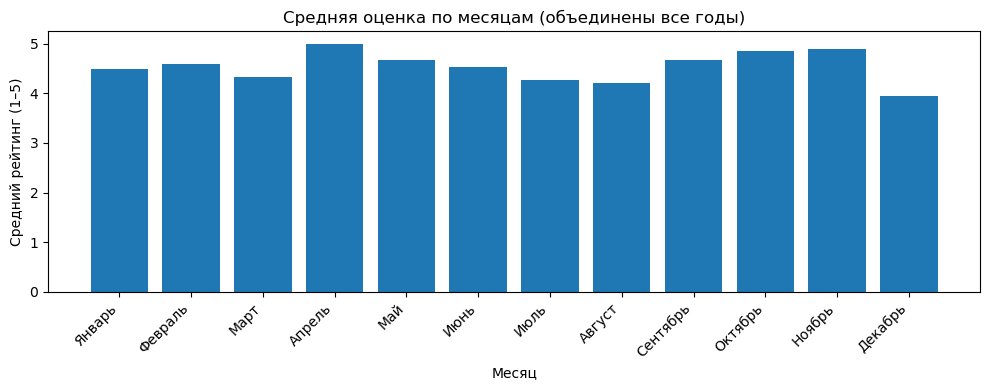

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# --- русские месяцы ---
RU_MONTHS = {
    1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
    5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
    9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
}

# Проверяем, что у нас есть Год/Месяц
if not {"Год", "Месяц", "Рейтинг"}.issubset(df.columns):
    raise RuntimeError("В датасете нужны колонки 'Год', 'Месяц', 'Рейтинг'.")

# 1) Группируем только по номеру месяца (год игнорируем)
monthly_avg = (
    df.dropna(subset=["Месяц", "Рейтинг"])
      .groupby("Месяц")["Рейтинг"]
      .mean()
      .reindex(range(1, 13))  # чтобы месяцы шли в правильном порядке
)

# 2) Подписи оси X
labels = [RU_MONTHS[m] for m in monthly_avg.index]

# 3) Построение графика
plt.figure(figsize=(10, 4))
plt.bar(labels, monthly_avg.values)
plt.title("Средняя оценка по месяцам (объединены все годы)")
plt.xlabel("Месяц")
plt.ylabel("Средний рейтинг (1–5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


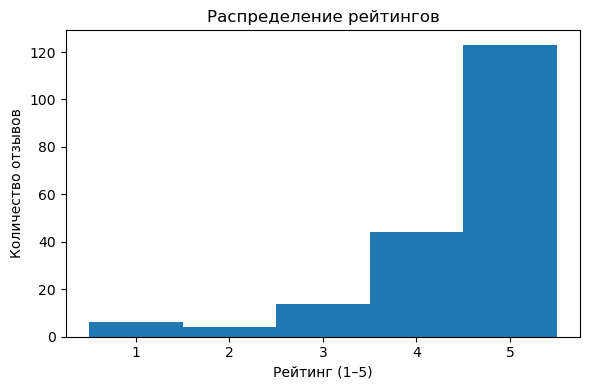

In [61]:
import matplotlib.pyplot as plt

vals = df["Рейтинг"].dropna().values

plt.figure(figsize=(6,4))
# ставим бины ровно по границам между звёздами
plt.hist(vals, bins=[0.5,1.5,2.5,3.5,4.5,5.5])

plt.title("Распределение рейтингов")
plt.xlabel("Рейтинг (1–5)")
plt.ylabel("Количество отзывов")
plt.xticks([1,2,3,4,5])   # жёстко задаём подписи
plt.tight_layout()
plt.show()



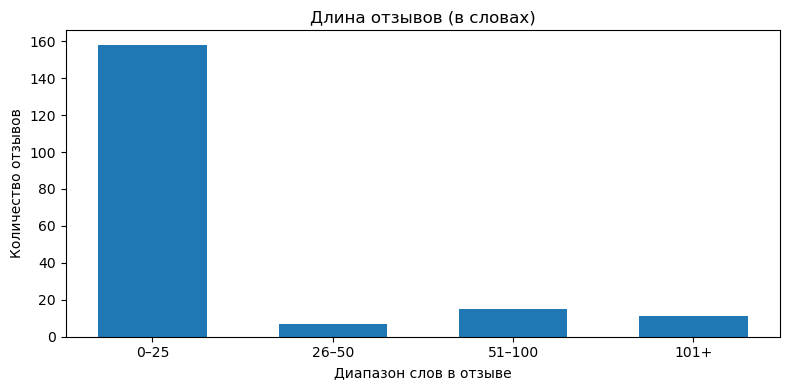

In [70]:
import matplotlib.pyplot as plt

# колонка с текстом
text_col = None
for c in ["Текст отзыва", "text", "review_text", "snippet"]:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise RuntimeError("Не найдена колонка с текстом отзыва.")

text = df[text_col].fillna("").astype(str).str.strip()
word_len = text.apply(lambda s: len(s.split()))

# Определяем группы
bins = [0, 25, 50, 100]
labels = ["0–25", "26–50", "51–100", "101+"]

counts = [
    (word_len <= 25).sum(),
    ((word_len > 25) & (word_len <= 50)).sum(),
    ((word_len > 50) & (word_len <= 100)).sum(),
    (word_len > 100).sum()
]

# Рисуем bar с одинаковой шириной
plt.figure(figsize=(8,4))
plt.bar(labels, counts, width=0.6)

plt.title("Длина отзывов (в словах)")
plt.xlabel("Диапазон слов в отзыве")
plt.ylabel("Количество отзывов")
plt.tight_layout()
plt.show()


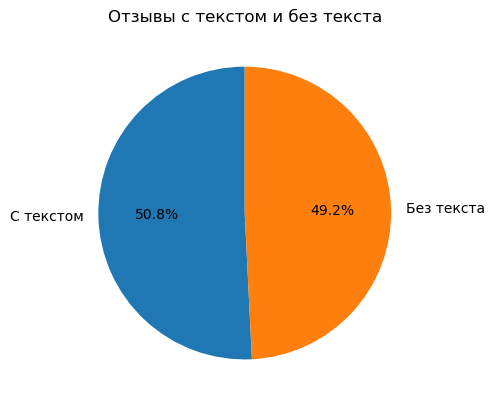

In [75]:
import matplotlib.pyplot as plt

# колонка с текстом
text_col = None
for c in ["Текст отзыва", "text", "review_text", "snippet"]:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise RuntimeError("Не найдена колонка с текстом отзыва.")

text = df[text_col].fillna("").astype(str).str.strip()
has_text = text.str.len() > 0

counts = [has_text.sum(), (~has_text).sum()]
labels = ["С текстом", "Без текста"]

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Отзывы с текстом и без текста")
plt.tight_layout()
plt.show()


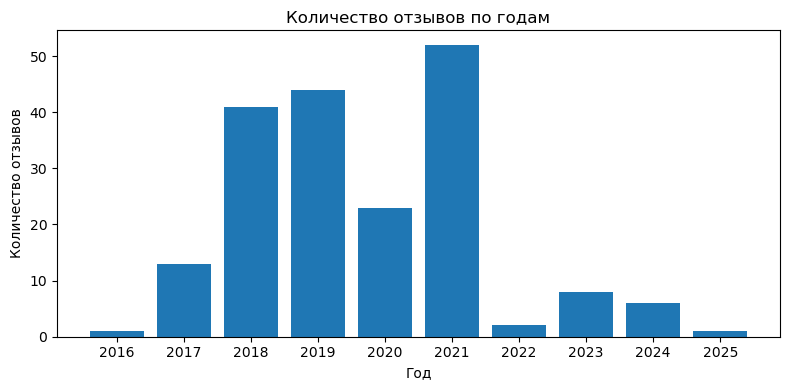

In [72]:
import matplotlib.pyplot as plt

if "Год" not in df.columns:
    raise RuntimeError("Нет колонки 'Год'.")

by_year = (df.dropna(subset=["Год"])
             .astype({"Год":"int"})
             .groupby("Год")
             .size()
             .sort_index())

plt.figure(figsize=(8,4))
plt.bar(by_year.index.astype(str), by_year.values)
plt.title("Количество отзывов по годам")
plt.xlabel("Год")
plt.ylabel("Количество отзывов")
plt.tight_layout(); plt.show()


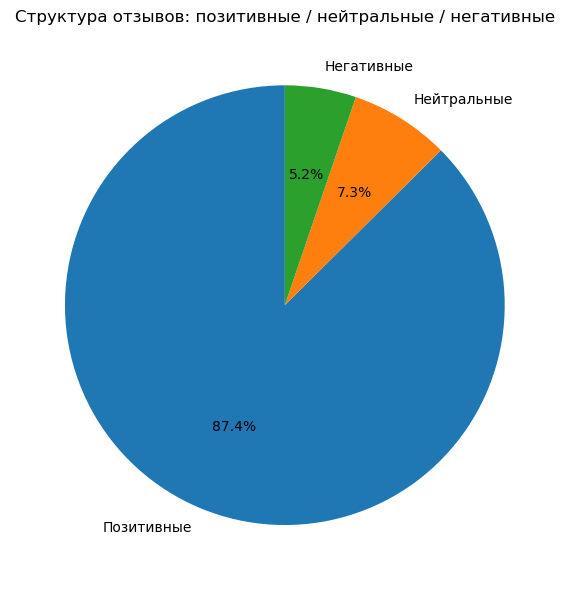

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Берём нормализованный рейтинг
if "Рейтинг" not in df.columns:
    raise RuntimeError("Нет колонки 'Рейтинг'.")

r = pd.to_numeric(df["Рейтинг"], errors="coerce")

# Категории: ≥4 → позитивные, =3 → нейтральные, ≤2 → негативные
cats = pd.Series(
    np.where(r >= 4, "Позитивные",
    np.where(r <= 2, "Негативные", "Нейтральные"))
)

counts = cats.value_counts().reindex(["Позитивные","Нейтральные","Негативные"]).fillna(0)

plt.figure(figsize=(6,6))
plt.pie(counts.values, labels=counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Структура отзывов: позитивные / нейтральные / негативные")
plt.tight_layout()
plt.show()
